# Pretrained Image classification example - Transformer
- Pretrained image classification using a Transformer architecture, "custom" Optimizer for OpenML Task (362127) , tiniest ImageNet dataset.

In [ ]:
import torch.nn
import torch.optim

import openml
import openml_pytorch
import openml_pytorch.layers
import openml_pytorch.config
from openml import OpenMLTask
import logging
import warnings
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
from openml_pytorch.trainer import convert_to_rgb
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore')

############################################################################
# Enable logging in order to observe the progress while running the example.
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
############################################################################

############################################################################
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# openml.config.apikey = 'key'
from openml_pytorch.trainer import OpenMLTrainerModule
from openml_pytorch.trainer import OpenMLDataModule
from openml_pytorch.trainer import Callback

## Define the Model

In [ ]:
# Example model. You can do better :)
import torchvision.models as models

# Load the pre-trained ResNet model
model = models.efficientnet_b0(pretrained=True)

# Modify the last fully connected layer to the required number of classes
num_classes = 200
in_features = model.classifier[-1].in_features
# model.fc = nn.Linear(in_features, num_classes)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, num_classes),
)

# Optional: If you're fine-tuning, you may want to freeze the pre-trained layers
# for param in model.parameters():
#     param.requires_grad = False

# # If you want to train the last layer only (the newly added layer)
# for param in model.fc.parameters():
#     param.requires_grad = True

## Configure the Data Module

In [ ]:
transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(
            convert_to_rgb
        ),  # Convert PIL Image to RGB if it's not already.
        Resize(
            (64, 64)
        ),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="Class_encoded",
    batch_size = 64,
    transform=transform
)

## Configure the Trainer Module

In [ ]:
def custom_optimizer_gen(model: torch.nn.Module, task: OpenMLTask) -> torch.optim.Optimizer:
    return torch.optim.Adam(model.fc.parameters())

trainer = OpenMLTrainerModule(
    data_module=data_module,
    verbose = True,
    epoch_count = 1,
    optimizer = custom_optimizer_gen,
    callbacks=[],
)
openml_pytorch.config.trainer = trainer

## Download the task

In [ ]:

# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(362127)

## Run the model on the task

In [ ]:
#
# Run the model on the task (requires an API key).m
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View loss

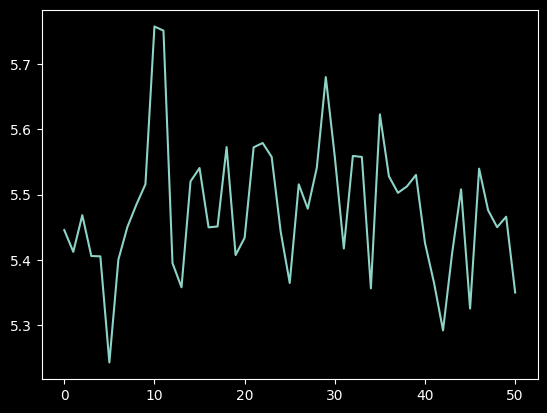

In [ ]:
trainer.runner.cbs[1].plot_loss()

## View learning rate

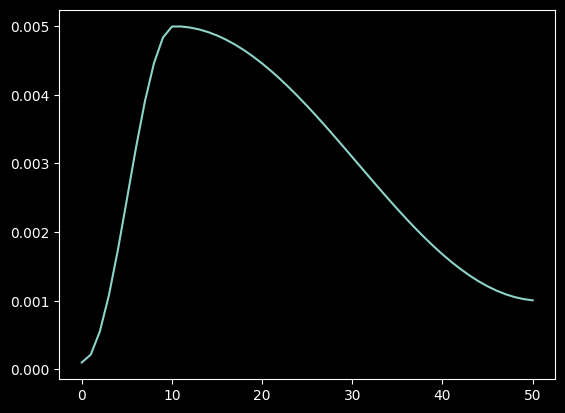

In [ ]:
trainer.runner.cbs[1].plot_lr()

## Publish the run to OpenML

In [ ]:
run.publish()